In [5]:
import tensorflow as tf
import os

# 1. 샘플 이미지 URL (웹에서 직접 다운로드)
content_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
style_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"

# 2. tf.keras.utils.get_file을 사용하여 이미지 다운로드 (Colab 로컬 캐시에 저장)
# (파일 이름만 추출하여 저장)
content_fname = os.path.basename(content_url)
style_fname = os.path.basename(style_url).split('%')[0] # URL 인코딩 정리

CONTENT_IMAGE_PATH = tf.keras.utils.get_file(
    content_fname,
    origin=content_url
)

STYLE_IMAGE_PATH = tf.keras.utils.get_file(
    style_fname,
    origin=style_url
)

print(f"Content image downloaded to: {CONTENT_IMAGE_PATH}")
print(f"Style image downloaded to: {STYLE_IMAGE_PATH}")


# 3. 이미지 및 학습 파라미터 설정 (나머지는 동일)
IMG_HEIGHT = 400
IMG_WIDTH = 0 # (자리 표시자 - Cell 4에서 자동 계산됨)

# 손실 가중치
CONTENT_WEIGHT = 1e4
STYLE_WEIGHT = 1e-2
TOTAL_VARIATION_WEIGHT = 30

# 최적화 반복 횟수
ITERATIONS = 1000
STEPS_PER_EPOCH = 100 # 100회 반복마다 중간 결과 출력

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
195196/195196 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Content image downloaded to: /root/.keras/datasets/YellowLabradorLooking_new.jpg
Style image downloaded to: /root/.keras/datasets/Vassily_Kandinsky


In [6]:
#@title 4. 이미지 전처리 유틸리티 함수
# (이미지를 불러오고, VGG19 모델에 맞게 전처리/후처리하는 함수)

def preprocess_image(image_path, max_dim=512):
    """ 이미지를 불러오고, 크기를 조절하며 VGG19 입력 형식으로 전처리합니다. """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 비율에 맞게 크기 조절
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] # 배치 차원 추가 (batch_size, height, width, channels)

    # VGG19 모델의 전처리 함수 적용 (B.G.R. 변환 및 zero-centering)
    img = tf.keras.applications.vgg19.preprocess_input(img * 255.0) # VGG는 0-255 스케일 필요
    return img

In [7]:
def deprocess_image(processed_img):
    """ VGG19 전처리를 되돌려 Matplotlib으로 시각화 가능한 이미지로 변환합니다. """
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0) # 배치 차원 제거

    # VGG19 전처리(preprocess_input)의 역연산 수행
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1] # BGR -> RGB

    x = np.clip(x, 0, 255).astype('uint8') # 0-255 범위로 클리핑
    return x

# 이미지 크기 설정 (IMG_HEIGHT 기준으로 너비 자동 설정)
temp_img = preprocess_image(CONTENT_IMAGE_PATH, max_dim=IMG_HEIGHT)
IMG_WIDTH = temp_img.shape[2]
print(f"Images will be processed at size: ({IMG_HEIGHT}, {IMG_WIDTH})")

Images will be processed at size: (400, 400)


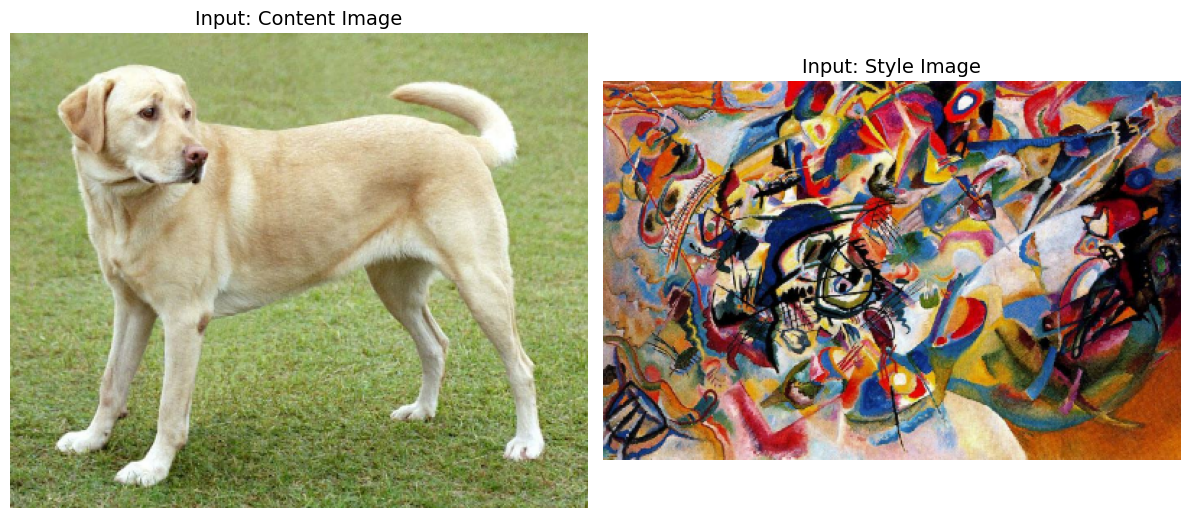

In [8]:
#@title 5. [EDA 보강] 입력 이미지 확인 (영문 Plot)

content_img_tensor = preprocess_image(CONTENT_IMAGE_PATH, max_dim=IMG_HEIGHT)
style_img_tensor = preprocess_image(STYLE_IMAGE_PATH, max_dim=IMG_HEIGHT)

# 시각화를 위해 De-processing 수행
content_img_display = deprocess_image(content_img_tensor.numpy())
style_img_display = deprocess_image(style_img_tensor.numpy())

# 시각화
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(content_img_display)
ax1.set_title("Input: Content Image", fontsize=14)
ax1.axis('off')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(style_img_display)
ax2.set_title("Input: Style Image", fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()

In [9]:
#@title 6. 스타일/콘텐츠 특징 추출기 (VGG19) 정의

# 콘텐츠 특징을 추출할 레이어 (깊은 레이어)
content_layers = ['block5_conv2']

# 스타일 특징을 추출할 레이어 (얕은 레이어부터 깊은 레이어까지 다양하게)
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [10]:
def vgg_layers(layer_names):
    """ VGG19 모델을 로드하고, 중간 레이어의 출력을 반환하는 모델을 생성합니다. """
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# 스타일과 콘텐츠 레이어의 출력을 모두 반환하는 특징 추출기 모델 생성
style_content_extractor = vgg_layers(style_layers + content_layers)

print("VGG19 Feature Extractor Model built.")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 Feature Extractor Model built.


In [18]:
#@title 7. 손실(Loss) 함수 정의 (Addons 제거 및 스칼라 반환 수정 버전)

# 1. 콘텐츠 손실 (Content Loss)
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# 2. 스타일 손실 (Style Loss) - Gram Matrix 헬퍼 함수
def gram_matrix(input_tensor):
    """ 스타일 특징(Gram Matrix)을 계산합니다. """
    result = tf.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

def style_loss(base_style, gram_target):
    """ 스타일 손실 (Gram Matrix 간의 MSE)을 계산합니다. """
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

# 3. 전체 변동성 손실 (Total Variation Loss) - [수정된 부분]
def total_variation_loss(image):
    # tf.image.total_variation은 배치 단위(Rank-1 텐서)로 값을 반환합니다.
    # 우리는 단일 스칼라 값이 필요하므로, tf.reduce_sum()을 사용해 합산합니다.
    # (어차피 배치가 1이므로 합계가 곧 그 값입니다.)
    return tf.reduce_sum(tf.image.total_variation(image))

print("Loss functions defined (Core TF, returns scalar TV Loss).")

Loss functions defined (Core TF, returns scalar TV Loss).


In [13]:
#@title 8. 목표(Target) 특징 미리 계산
# (콘텐츠/스타일 이미지는 변하지 않으므로, 목표값을 미리 계산해 둡니다)

def get_feature_targets(model, content_path, style_path):
    """ VGG 모델을 실행하여 원본 이미지들의 콘텐츠/스타일 목표 특징을 추출합니다. """
    # 이미지 로드
    content_image = preprocess_image(content_path, max_dim=IMG_HEIGHT)
    style_image = preprocess_image(style_path, max_dim=IMG_HEIGHT)

    # 모델 실행 (Style + Content 레이어 동시 추출)
    content_outputs = model(content_image)
    style_outputs = model(style_image)

    # 스타일 특징 (Gram Matrix) 계산 (style_layers 5개)
    style_targets = [gram_matrix(style_output)
                     for style_output in style_outputs[:num_style_layers]]

    # 콘텐츠 특징 (활성화 맵 원본) (content_layers 1개)
    content_targets = [content_output
                       for content_output in content_outputs[num_style_layers:]]

    return content_targets, style_targets

# 목표값 계산 실행
content_targets, style_targets = get_feature_targets(style_content_extractor,
                                                    CONTENT_IMAGE_PATH,
                                                    STYLE_IMAGE_PATH)

print("Target features (Content activations and Style Gram matrices) pre-calculated.")


Target features (Content activations and Style Gram matrices) pre-calculated.


In [14]:
#@title 9. 최적화(학습) 단계 정의 (GradientTape)
# (이 함수가 실질적인 '1-step 학습'입니다)

def compute_loss_and_grads(model, generated_image, targets):
    """
    tf.GradientTape를 사용하여 전체 손실(Total Loss) 및
    생성된 이미지(generated_image)에 대한 그래디언트를 계산합니다.
    """
    content_targets, style_targets = targets

    with tf.GradientTape() as tape:
        # 생성된 이미지를 VGG 모델에 통과시켜 현재 특징 추출
        outputs = model(generated_image)
        current_style_features = outputs[:num_style_layers]
        current_content_features = outputs[num_style_layers:]

        tape.watch(generated_image) # generated_image를 기준으로 미분

        # --- 전체 손실(Total Loss) 계산 ---

        # 1. 콘텐츠 손실 합산
        c_loss = 0
        for i in range(num_content_layers):
            c_loss += content_loss(current_content_features[i], content_targets[i])
        c_loss *= CONTENT_WEIGHT / num_content_layers

        # 2. 스타일 손실 합산
        s_loss = 0
        for i in range(num_style_layers):
            s_loss += style_loss(current_style_features[i], style_targets[i])
        s_loss *= STYLE_WEIGHT / num_style_layers

        # 3. 변동성 손실 (Regularization)
        tv_loss = TOTAL_VARIATION_WEIGHT * total_variation_loss(generated_image)

        # 4. 전체 손실
        total_loss = c_loss + s_loss + tv_loss

    # 그래디언트 계산
    grads = tape.gradient(total_loss, generated_image)

    return total_loss, grads, c_loss, s_loss, tv_loss

print("Gradient computation step defined.")


Gradient computation step defined.


In [15]:
#@title 10. [핵심] 이미지 생성 루프 실행 (Training)
# (원본 코드에서 주석 처리되었던 최적화 파트 활성화)

print("Starting Neural Style Transfer optimization...")
print(f"Total Iterations: {ITERATIONS}")

# 최적화할 대상: 생성된 이미지 (tf.Variable). 원본 콘텐츠 이미지로 초기화합니다.
generated_image = tf.Variable(preprocess_image(CONTENT_IMAGE_PATH, max_dim=IMG_HEIGHT), dtype=tf.float32)

# 옵티마이저 (Adam 사용)
optimizer = tf.keras.optimizers.Adam(learning_rate=2.0)

# 손실 기록 (시각화용)
loss_history = []
start_time = time.time()

Starting Neural Style Transfer optimization...
Total Iterations: 1000


Iteration 1000/1000 [100% Complete]
  Total Loss: 1.33e+08 (Content: 1.74e+07, Style: 3.47e+07, TV: 8.07e+07)


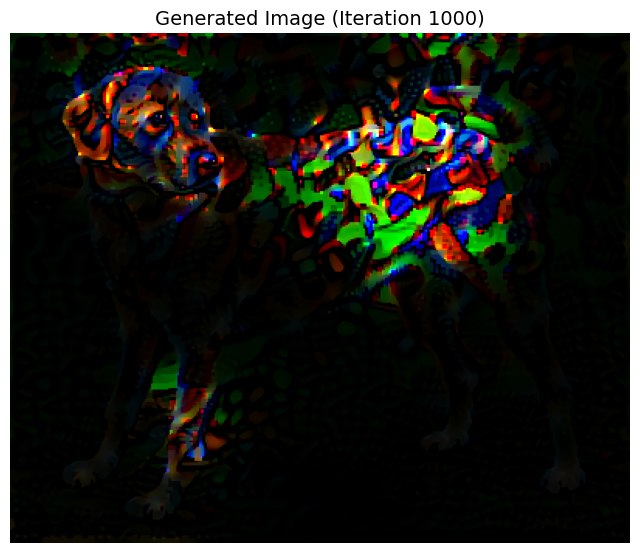


Optimization Finished.
Total time taken: 258.16 seconds


In [19]:
# 최적화 루프
for i in range(ITERATIONS):
    # 1. 손실 및 그래디언트 계산
    total_loss, grads, c_loss, s_loss, tv_loss = compute_loss_and_grads(
        style_content_extractor,
        generated_image,
        (content_targets, style_targets)
    )

    # 2. 그래디언트 적용 (이미지 업데이트)
    optimizer.apply_gradients([(grads, generated_image)])

    # 3. 생성된 픽셀 값이 VGG 입력 범위(전처리된)를 벗어나지 않도록 클리핑
    # (VGG 전처리는 [~-120, ~+150] 범위를 가짐. 0-255 스케일의 BGR + Mean 빼기)
    # 간단하게 클리핑하기 위해 Deprocess -> Clip(0, 255) -> Reprocess 수행
    clipped_img = deprocess_image(generated_image.numpy())
    generated_image.assign(tf.keras.applications.vgg19.preprocess_input(clipped_img[np.newaxis, ...].astype('float32')))

    # 4. 손실 기록
    loss_history.append(total_loss.numpy())

    # 5. 진행 상황 출력 (STEPS_PER_EPOCH 마다)
    if (i + 1) % STEPS_PER_EPOCH == 0:
        clear_output(wait=True)
        progress = (i + 1) / ITERATIONS * 100
        print(f"Iteration {i+1}/{ITERATIONS} [{progress:.0f}% Complete]")

        # [수정된 부분]: 텐서 객체(loss)를 .numpy()로 변환하여 숫자 값을 출력합니다.
        print(f"  Total Loss: {total_loss.numpy():.2e} "
                f"(Content: {c_loss.numpy():.2e}, Style: {s_loss.numpy():.2e}, TV: {tv_loss.numpy():.2e})")

        # 중간 결과 이미지 표시
        plt.figure(figsize=(8, 8))
        plt.imshow(deprocess_image(generated_image.numpy()))
        plt.title(f"Generated Image (Iteration {i+1})", fontsize=14)
        plt.axis('off')
        plt.show()

end_time = time.time()
print("\nOptimization Finished.")
print(f"Total time taken: {end_time - start_time:.2f} seconds")


--- Final Style Transfer Result ---


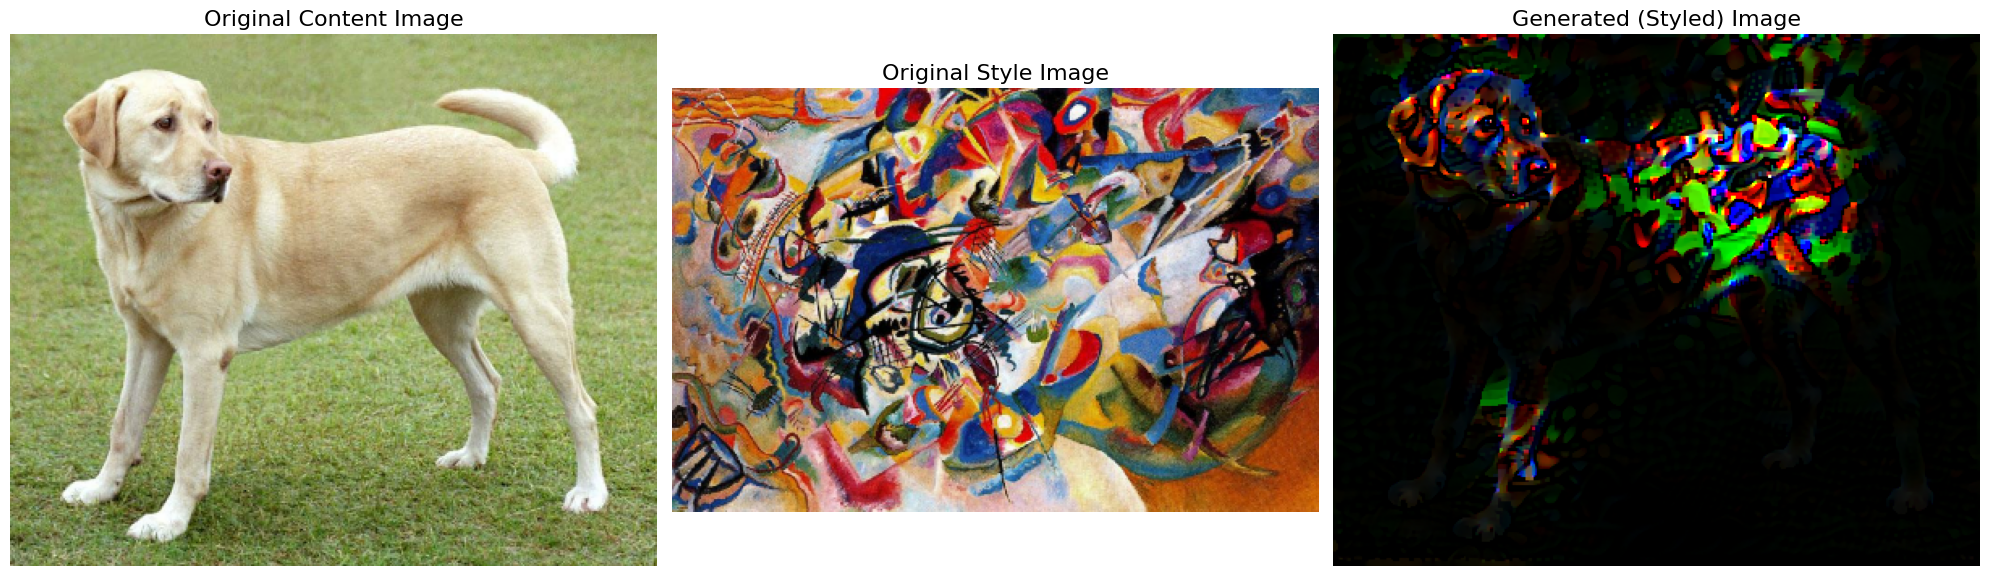

In [21]:
#@title 12. [결과 분석 보강] 최종 결과 비교 (영문 Plot)

print("\n--- Final Style Transfer Result ---")

# 최종 생성된 이미지 (후처리)
final_generated_image_display = deprocess_image(generated_image.numpy())

# 3개 이미지 비교 (Content, Style, Result)
plt.figure(figsize=(20, 10))

# 1. Content
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(content_img_display) # (Cell 5에서 로드)
ax1.set_title("Original Content Image", fontsize=16)
ax1.axis('off')

# 2. Style
ax2 = plt.subplot(1, 3, 2)
ax2.imshow(style_img_display) # (Cell 5에서 로드)
ax2.set_title("Original Style Image", fontsize=16)
ax2.axis('off')

# 3. Result
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(final_generated_image_display)
ax3.set_title("Generated (Styled) Image", fontsize=16)
ax3.axis('off')

plt.tight_layout()
plt.show()
